# NAME

# Import and Setup

# Function

# Main

In [1]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
from torch import tensor, nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder

In [3]:
from matplotlib import pyplot as plt

In [4]:
# !pip3 install albumentations

In [5]:
# !pip3 install torch --upgrade

In [6]:
# !pip3 install timm

In [7]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [8]:
## Timm list model
model_names = timm.list_models('*nfnet*', pretrained=True)
model_names

['dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'nfnet_l0']

In [9]:
csv_train = "../../../shopee-product-matching/train.csv"
image_folder = "../../../shopee-product-matching/train_images/"

In [10]:
df = pd.read_csv(csv_train)
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [11]:
# class ShopeeDataset(Dataset):
    
#     def __init__(self, df, image_folder):
#         super().__init__()
#         self.df = df.reset_index(drop=True)
#         self.image_folder = image_folder
#         self.img_sizes = [(512, 512), (384, 384)]
#         self.tokenizers = tokenizers

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
        
#         img = cv2.imread(f"/kaggle/input/shopee-product-matching/{row.path}_images/{row.image}")
        
#         outs = [torch.FloatTensor(cv2.resize(img, size)).permute(2, 0, 1)/255.0 for size in self.img_sizes]
        
#         for i in range(len(tokenizers)):
#             inputs = self.tokenizers[i].encode_plus(
#                 row.title,
#                 None,
#                 add_special_tokens=True,
#                 max_length=MAX_LEN,
#                 padding="max_length",
#                 return_token_type_ids=True,
#                 truncation=True
#             )
#             outs.append(torch.LongTensor(inputs['input_ids']))
#             outs.append(torch.LongTensor(inputs['attention_mask']))
#         return tuple(outs)

#     def __len__(self):
#         return self.df.shape[0]

In [12]:
# ShopeeDataset(df, image_folder)

In [13]:
class ShopeeDataset(Dataset):
    
    def __init__(self, df, image_folder, transform = None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        img_path = os.path.join(image_folder,row.image)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = row.label_group
        
        return {
            "image": image,
            "label": tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return self.df.shape[0]

In [14]:
IMG_SIZE = 512
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
    
transform = albumentations.Compose([
                albumentations.Resize(IMG_SIZE,IMG_SIZE,always_apply=True),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
                albumentations.Rotate(limit=120, p=0.8),
#                 albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
#                 albumentations.Normalize(mean = MEAN, std = STD),
#                 ToTensorV2(p=1.0),  ## outshape [w,h,3] -> [3,w,h]
            ])
dataset = ShopeeDataset(df, image_folder, transform=transform)
print(len(dataset))
# plt.imshow(dataset[100]["image"])

34250


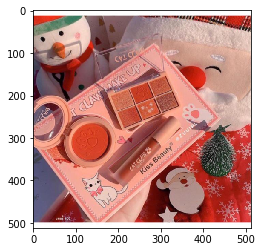

In [15]:
plt.imshow(dataset[100]["image"])

In [16]:
## model

In [17]:
class CFG:
    EPOCHS = 1 #15
    BATCH_SIZE = 8
    
    NUM_WORKERS = 1 #4
    DEVICE = 'cpu'
    # DEVICE = 'cuda'
    
    CLASSES = 11014 # len(df.label_group.unique())
    SCALE = 30
    MARGIN = 0.5
    
    MODEL_NAME = 'eca_nfnet_l0'
    FC_DIM = 512
    
    SCHEDULER_PARAMS = {
            "lr_start": 1e-5,
            "lr_max": 1e-5 * 32,
            "lr_min": 1e-6,
            "lr_ramp_ep": 5,
            "lr_sus_ep": 0,
            "lr_decay": 0.8,
        }

In [18]:
'''
credit : https://github.com/HuangYG123/CurricularFace/blob/8b2f47318117995aa05490c05b455b113489917e/head/metrics.py#L70
paper  : https://arxiv.org/abs/2004.00288
'''

def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output

class CurricularFace(nn.Module):
    def __init__(self, in_features, out_features, s = 30, m = 0.50):
        super(CurricularFace, self).__init__()

        print('Using Curricular Face')

        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.s = s
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.threshold = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.kernel = nn.Parameter(torch.Tensor(in_features, out_features))
        self.register_buffer('t', torch.zeros(1))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(self.kernel, axis = 0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        mask = cos_theta > cos_theta_m
        final_target_logit = torch.where(target_logit > self.threshold, cos_theta_m, target_logit - self.mm)

        hard_example = cos_theta[mask]
        with torch.no_grad():
            self.t = target_logit.mean() * 0.01 + (1 - 0.01) * self.t
        cos_theta[mask] = hard_example * (self.t + hard_example)
        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        output = cos_theta * self.s
        return output, nn.CrossEntropyLoss()(output,label)

In [19]:
class ShopeeCurricularFaceModel(nn.Module):

    def __init__(
        self,
        n_classes = CFG.CLASSES,
        model_name = CFG.MODEL_NAME,
        fc_dim = CFG.FC_DIM,
        margin = CFG.MARGIN,
        scale = CFG.SCALE,
        use_fc = True,
        pretrained = True):


        super(ShopeeCurricularFaceModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_fc_params()
            final_in_features = fc_dim

        self.final = CurricularFace(final_in_features, 
                                           n_classes, 
                                           s=scale, 
                                           m=margin)

    def _init_fc_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [20]:
ShopeeCurricularFaceModel()

Building Model Backbone for eca_nfnet_l0 model
Using Curricular Face


ShopeeCurricularFaceModel(
  (backbone): NormFreeNet(
    (stem): Sequential(
      (conv1): ScaledStdConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act2): SiLU(inplace=True)
      (conv2): ScaledStdConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act3): SiLU(inplace=True)
      (conv3): ScaledStdConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act4): SiLU(inplace=True)
      (conv4): ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (stages): Sequential(
      (0): Sequential(
        (0): NormFreeBlock(
          (downsample): DownsampleAvg(
            (pool): Identity()
            (conv): ScaledStdConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (act1): SiLU()
          (conv1): ScaledStdConv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
          (act2): SiLU(inplace=True)
          (conv2): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [22]:
import torch 
from torch.optim.lr_scheduler import _LRScheduler

class ShopeeScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ShopeeScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [23]:
import torch 
from torch import nn 
from torch.optim.optimizer import Optimizer

import math


def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    '''credit - https://github.com/Yonghongwei/Gradient-Centralization '''
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [24]:
import torch 
from torch import nn 
import torch.nn.functional as F

class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [50]:
def train_fn(model, data_loader, optimizer, scheduler, i):
    model.train()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [TRAIN] " + str(i+1))

    for t,data in enumerate(tk):
        for k,v in data.items():
            data[k] = v.to(CFG.DEVICE)
        data['image'] = data['image'].float()
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step() 
        fin_loss += loss.item() 

        tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1)), 'LR' : optimizer.param_groups[0]['lr']})

    scheduler.step()

    return fin_loss / len(data_loader)

def eval_fn(model, data_loader, i):
    model.eval()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [VALID] " + str(i+1))

    with torch.no_grad():
        for t,data in enumerate(tk):
            for k,v in data.items():
                data[k] = v.to(CFG.DEVICE)
            _, loss = model(**data)
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1))})
        return fin_loss / len(data_loader)

In [55]:
df = pd.read_csv(csv_train)
labelencoder= LabelEncoder()
df['label_group'] = labelencoder.fit_transform(df['label_group'])

# trainset = ShopeeDataset(df, transform = get_train_transforms())
IMG_SIZE = 512
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
    
transform = albumentations.Compose([
                albumentations.Resize(IMG_SIZE,IMG_SIZE,always_apply=True),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
                albumentations.Rotate(limit=120, p=0.8),
                albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
                albumentations.Normalize(mean = MEAN, std = STD),
                ToTensorV2(p=1.0),  ## outshape [w,h,3] -> [3,w,h]
                albumentations.ToFloat(None, p=1.0)
            ])
trainset = ShopeeDataset(df[0:100], image_folder, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = CFG.BATCH_SIZE,
    pin_memory = True,
#     num_workers = 4, #CFG.NUM_WORKERS,
    shuffle = True,
    drop_last = True
)

print(df['label_group'].nunique())

model = ShopeeCurricularFaceModel(n_classes = df['label_group'].nunique())
# model = replace_activations(model, nn.SiLU, Mish())
model.to(CFG.DEVICE)

optimizer = Ranger(model.parameters(), lr = CFG.SCHEDULER_PARAMS['lr_start'])
# optimizer = torch.optim.Adam(model.parameters(), lr = config.SCHEDULER_PARAMS['lr_start'])
scheduler = ShopeeScheduler(optimizer,**CFG.SCHEDULER_PARAMS)

print("START Training ... ")
for i in range(CFG.EPOCHS):
    avg_loss_train = train_fn(model, trainloader, optimizer, scheduler, i)
    #torch.save(model.state_dict(),'c_face_eca_nfnet_l0.pt')

11014
Building Model Backbone for eca_nfnet_l0 model


Epoch [TRAIN] 1:   0%|          | 0/12 [00:00<?, ?it/s]

Using Curricular Face
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
START Training ... 


Epoch [TRAIN] 1:   8%|▊         | 1/12 [01:19<14:38, 79.83s/it, loss=23.578032, LR=1e-5]


KeyboardInterrupt: 